# Лабораторная работа № 1
## Выполнил: Яковлев Артур, 853501
## Проверил: Бутома В. С.

## Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Реализация генератора двумерной дискретной случайной величины

In [2]:
class DiscreteGenerator:
    def __init__(self, matrix, x_values=None, y_values=None):
        if x_values is None:
            x_values = np.arange(matrix.shape[1])
        if y_values is None:
            y_values = np.arange(matrix.shape[0])
        self.x_values = x_values
        self.y_values = y_values
        
        assert abs(np.sum(matrix) - 1.) < 1e-9
        assert x_values.shape[0] == matrix.shape[1]
        assert y_values.shape[0] == matrix.shape[0]
        
        self.row_partial_sums = np.sum(matrix, axis=1)
        for i in range(1, len(self.row_partial_sums)):
            self.row_partial_sums[i] += self.row_partial_sums[i - 1]
        
        self.partial_sums = matrix.copy()
        for i in range(1, matrix.shape[1]):
            self.partial_sums[:, i] += self.partial_sums[:, i - 1]
    
    def _get_value(self, num):
        row = np.searchsorted(self.row_partial_sums, num[0])
        column = np.searchsorted(self.partial_sums[row], num[1] * self.partial_sums[row, -1])
        return row, column
    
    def __iter__(self):
        return self
    
    def __next__(self):
        num = np.random.rand(2)
        return self._get_value(num)

## Визуализация эмпирической матрицы распределения

In [3]:
def get_empiric_distribution_matrix(matrix, iters=10000):
    gen = DiscreteGenerator(matrix)
    empiric_matrix = np.zeros(matrix.shape)
    for i in range(iters):
        empiric_matrix[next(gen)] += 1
    empiric_matrix /= np.sum(empiric_matrix)
    return empiric_matrix

In [5]:
def test_generator():
    matrix = np.array([
        [0.1, 0.1, 0.2],
        [0.05, 0.05, 0.25],
        [0.15, 0.05, 0.05]
    ])
    array = get_empiric_distribution_matrix(matrix)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey='all')
    axes[0].set_title('Actual distribution')
    axes[1].set_title('Empiric distribution')
    sns.heatmap(matrix, ax=axes[0], cmap="Blues")
    sns.heatmap(array, ax=axes[1], cmap="Blues")

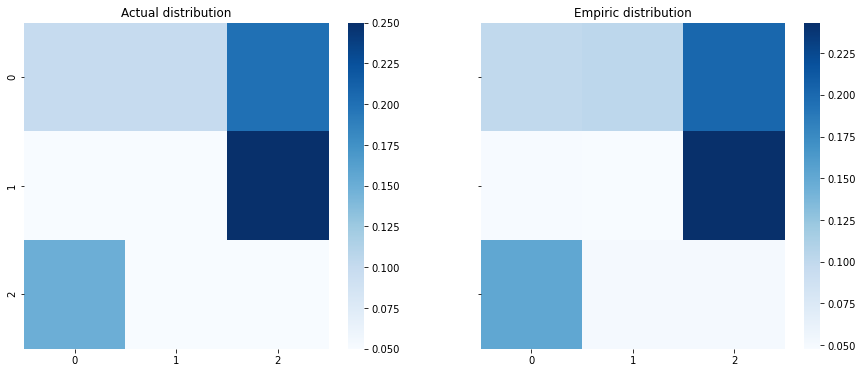

In [6]:
test_generator()

In [47]:
def plot_mse():
    
    def mse(first, second):
        return np.sqrt(np.sum((first - second) ** 2)) / np.prod(first.shape)
    
    matrix = np.random.rand(3, 3)
    matrix /= np.sum(matrix)
    iters = np.linspace(10, 100000, 20).astype(int)
    mse_values = []
    for amount in iters:
        mse_values.append(mse(matrix, get_empiric_distribution_matrix(matrix, amount)))
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), sharey='all')
    ax.set_title('Correlation between sample size and mean squared error', fontsize=16)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('MSE')
    sns.lineplot(x=iters, y=mse_values, label='MSE')

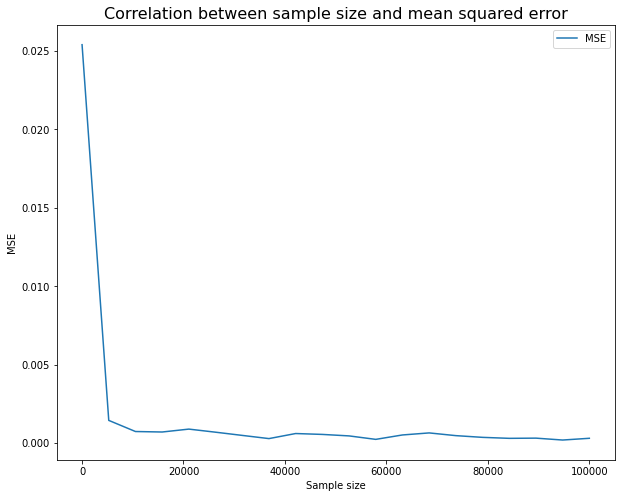

In [48]:
plot_mse()

## Гистограммы составляющих векторов

In [8]:
distribution_matrix = np.random.rand(5, 7)
distribution_matrix /= np.sum(distribution_matrix)
assert np.abs(np.sum(distribution_matrix) - 1.) < 1e-9
print(distribution_matrix)

[[0.04376321 0.06853776 0.00702727 0.00137347 0.01023812 0.01077274
  0.05584721]
 [0.02982123 0.02984554 0.02079834 0.00046412 0.00508643 0.01592466
  0.01391825]
 [0.05972394 0.0526147  0.0647482  0.05106828 0.01290165 0.00242053
  0.01939753]
 [0.07029166 0.02879508 0.00607782 0.03549844 0.05167124 0.01848998
  0.06680371]
 [0.05483741 0.00346788 0.00335199 0.02927766 0.01275909 0.03626564
  0.0061192 ]]


In [9]:
def build_histograms(matrix, iters=10000):
    x_probabilities = np.sum(matrix, axis=1)
    y_probabilities = np.sum(matrix, axis=0)
    empiric_matrix = get_empiric_distribution_matrix(matrix, iters)
    empiric_x_probabilities = np.sum(empiric_matrix, axis=1)
    empiric_y_probabilities = np.sum(empiric_matrix, axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey='all')
    fig.suptitle(f'X and Y distributions for {iters} generated values', fontsize=16)
    axes[0].set_title('X axis')
    axes[1].set_title('Y axis')
    sns.lineplot(x=np.arange(len(x_probabilities)), y=x_probabilities, color='red', ax=axes[0], label='Actual distribution')
    sns.lineplot(x=np.arange(len(y_probabilities)), y=y_probabilities, color='red', ax=axes[1], label='Actual distribution')
    
    for i, x in enumerate(empiric_x_probabilities):
        axes[0].plot([i, i], [0, x], 'o-', color='blue')
    for i, y in enumerate(empiric_y_probabilities):
        axes[1].plot([i, i], [0, y], 'o-', color='blue')

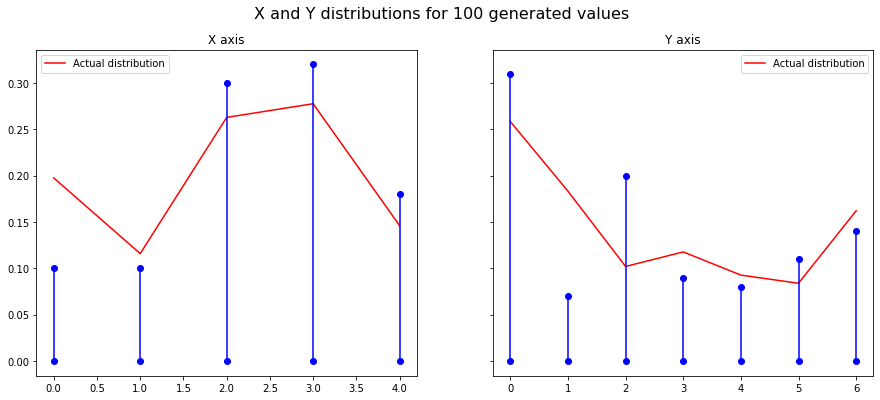

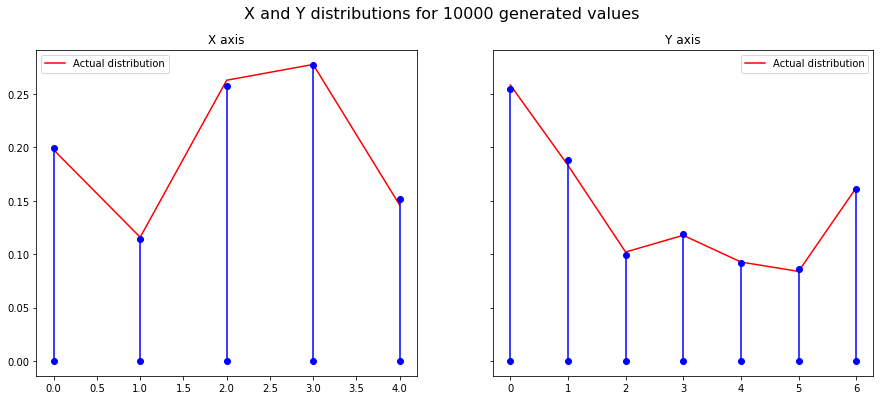

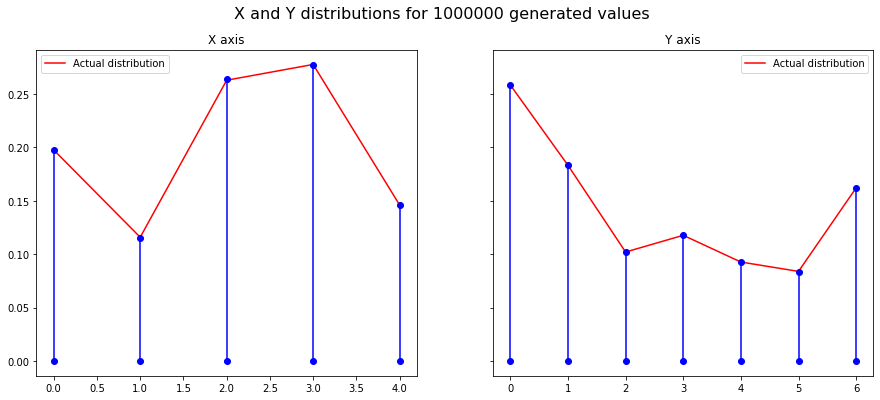

In [10]:
build_histograms(distribution_matrix, 100)
build_histograms(distribution_matrix, 10000)
build_histograms(distribution_matrix, 1000000)

## Статистическое исследование полученного распределения на основе критерия $\chi^2$

In [13]:
def chi_square_test(matrix, iters=10000):
    empiric_matrix = get_empiric_distribution_matrix(matrix, iters)
    test_value = np.sum(np.square(matrix - empiric_matrix) / matrix) * iters
    p_value = 1 - stats.chi2.cdf(test_value, np.prod(matrix.shape) - 1)
    return p_value

In [14]:
def plot_p_values(matrix):
    samples = np.linspace(10, 100000, 100).astype(int)
    p_values = [chi_square_test(matrix, sample) for sample in samples]
    plt.figure(figsize=(10, 8))
    plt.title('p-values for various amounts of random samples', fontsize=16)
    plt.ylabel('p_value')
    plt.xlabel('samples')
    plt.scatter(x=samples, y=p_values, s=14, marker='H')
    plt.plot(samples, [0.05] * len(samples), color='red', label='confidence level 0.95')
    plt.legend()

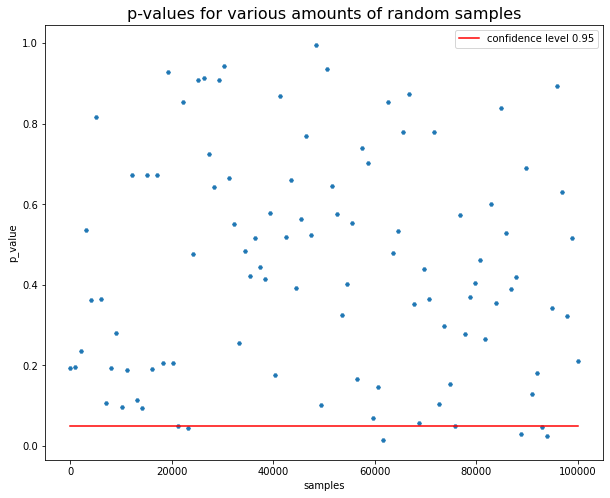

In [15]:
plot_p_values(distribution_matrix)

## Точечные и интервальные оценки математического ожидания

In [16]:
def expected_values(matrix):
    return np.arange(matrix.shape[0]) @ np.sum(matrix, axis=1), np.arange(matrix.shape[1]) @ np.sum(matrix, axis=0)

In [17]:
def expected_value_estimation(matrix, iters=10000):
    empiric_matrix = get_empiric_distribution_matrix(matrix, iters)
    real, generated = expected_values(matrix), expected_values(empiric_matrix)
    print(f'Actual values:\nE_x = {real[0]}, E_y = {real[1]}')
    print(f'Empiric values:\nE_x = {generated[0]}, E_y = {generated[1]}')

In [18]:
expected_value_estimation(distribution_matrix)

Actual values:
E_x = 2.058807556169798, E_y = 2.5028235104629752
Empiric values:
E_x = 2.0456, E_y = 2.4797


Для построения интервальных оценок будем использовать центральную предельную теорему. Зная, что наша величина имеет конечные математическое ожидание и дисперсию, имеем:

$$
\frac{\sum_{i=1}^{n}{X_i} - \mu n}{\sigma\sqrt{n}} \sim N(0, 1)
$$

или

$$
\sqrt{n}\frac{\overline{X} - \mu}{\sigma} \sim N(0, 1)
$$

Преобразуя данное выражение, можем получить доверительный интервал уровня $\alpha$

$$
\overline{X} - \frac{z_{1 - \frac{\alpha}{2}}}{\sqrt{n}}\sigma \leq \mu \leq \overline{X} + \frac{z_{1 - \frac{\alpha}{2}}}{\sqrt{n}}\sigma
$$

где $z_{1 - \frac{\alpha}{2}}$ является квантилем стандартного нормального распределения уровня $1 - \frac{\alpha}{2}$.


In [19]:
def variance(matrix):
    ex, ey = expected_values(matrix)
    return np.square(np.arange(matrix.shape[0])) @ np.sum(matrix, axis=1) - ex ** 2, np.square(np.arange(matrix.shape[1])) @ np.sum(matrix, axis=0) - ey ** 2

In [20]:
def expected_values_interval(matrix, ppf=0.05, iters=10000):
    empiric_matrix = get_empiric_distribution_matrix(matrix, iters)
    std_x, std_y = map(np.sqrt, variance(empiric_matrix))
    ex, ey = expected_values(empiric_matrix)
    z = stats.norm.ppf(1 - ppf / 2)
    return (ex - z * std_x / np.sqrt(iters), ex, ex + z * std_x / np.sqrt(iters)), (ey - z * std_y / np.sqrt(iters), ey, ey + z * std_y / np.sqrt(iters))

In [24]:
expected_values_interval(distribution_matrix)

((2.0086084621620506, 2.0346, 2.06059153783795),
 (2.4535835562938524, 2.4965, 2.539416443706148))

In [22]:
def plot_intervals(matrix, func, interval_func, ppf, samples, name):
    ex, ey = func(matrix)
    x_bounds = []
    y_bounds = []
    for sample in samples:
        x_, y_ = interval_func(matrix, ppf=ppf, iters=sample)
        x_bounds.append(x_)
        y_bounds.append(y_)
    x_bounds = np.array(x_bounds)
    y_bounds = np.array(y_bounds)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=False, sharey=False)
    fig.suptitle(f'Confidence intervals for {name}', fontsize=16)
    
    axes[0].set_title(f'{name} for X', fontsize=12)
    axes[0].plot(samples, [ex] * len(samples), color='red', label='Actual value')
    axes[0].plot(samples, x_bounds[:, 1], 'o-', color='green')
    axes[0].legend()
    axes[0].fill_between(samples, x_bounds[:, 0], x_bounds[:, 2], color='green', alpha=0.2)
    
    axes[1].set_title(f'{name} for Y', fontsize=12)
    axes[1].plot(samples, [ey] * len(samples), color='red', label='Actual value')
    axes[1].plot(samples, y_bounds[:, 1], 'o-', color='green')
    axes[1].fill_between(samples, y_bounds[:, 0], y_bounds[:, 2], color='green', alpha=0.2)
    axes[1].legend()

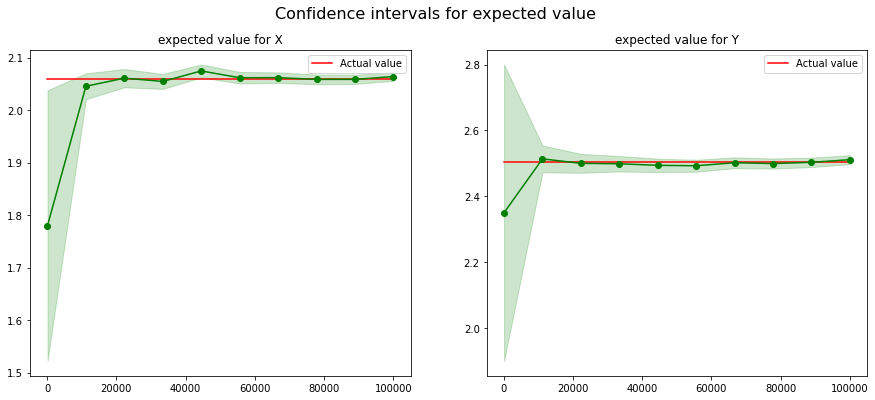

In [23]:
plot_intervals(distribution_matrix, expected_values, expected_values_interval, 0.05, np.linspace(100, 100000, 10).astype(int), 'expected value')

## Точечные и интервальные оценки дисперсии

In [265]:
def variance_estimation(matrix, iters=10000):
    empiric_matrix = get_empiric_distribution_matrix(matrix, iters)
    real, generated = variance(matrix), variance(empiric_matrix)
    print(f'Actual values:\nE_x = {real[0]}, E_y = {real[1]}')
    print(f'Empiric values:\nE_x = {generated[0]}, E_y = {generated[1]}')

In [266]:
variance_estimation(distribution_matrix)

Actual values:
E_x = 1.9885020747176103, E_y = 3.7859512096611248
Empiric values:
E_x = 1.984343749999999, E_y = 3.80739775


Для интервальной оценки дисперсии подходит та же центральная предельная теорема, однако необходимо знать дисперсию точечной оценки. Для ее нахождения будем использовать метод бутстрепа. В данном методе мы генерируем определенное количество значений из генератора на основе эмпирической матрицы распределения, находим для полученных наборов дисперсию и усредняем ее. При количестве наборов $b \geq 50$ оценка будет довольно точной.

In [25]:
def bootstrap(matrix, func, batches=50, size=1000):
    values = []
    for i in range(batches):
        values.append(func(get_empiric_distribution_matrix(matrix, size)))
    return np.var(values, axis=0)

In [27]:
def variance_interval(matrix, ppf=0.05, iters=10000):
    empiric_matrix = get_empiric_distribution_matrix(matrix, iters)
    std_x, std_y = map(np.sqrt, bootstrap(empiric_matrix, variance, 50, size=iters))
    ex, ey = variance(empiric_matrix)
    z = stats.norm.ppf(1 - ppf / 2)
    return (ex - z * std_x, ex, ex + z * std_x), (ey - z * std_y, ey, ey + z * std_y)

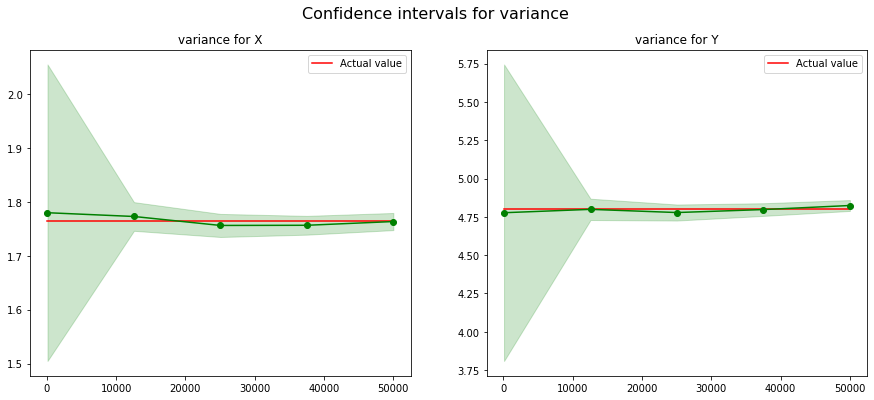

In [29]:
plot_intervals(distribution_matrix, variance, variance_interval, 0.05, np.linspace(100, 50000, 5).astype(int), 'variance')

## Оценка коэффициента корреляции

In [42]:
def covariation(matrix):
    return np.arange(matrix.shape[0]) @ matrix @ np.arange(matrix.shape[1]) - np.prod(expected_values(matrix))


def correlation_coeff(matrix):
    return covariation(matrix) / np.sqrt(np.prod(variance(matrix)))

In [43]:
correlation_coeff(distribution_matrix)

0.049767327171754375

In [44]:
def correlation_interval(matrix, ppf=0.05, iters=10000):
    empiric_matrix = get_empiric_distribution_matrix(matrix, iters)
    std = np.sqrt(bootstrap(empiric_matrix, correlation_coeff, 50, size=iters))
    e = correlation_coeff(empiric_matrix)
    z = stats.norm.ppf(1 - ppf / 2)
    return e - z * std, e, e + z * std

In [45]:
def plot_correlation(matrix, samples):
    real_correlation = correlation_coeff(matrix)
    intervals = []
    for sample in samples:
        intervals.append(correlation_interval(get_empiric_distribution_matrix(matrix, sample), 0.05, sample))
    intervals = np.array(intervals)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(f'Correlation', fontsize=16)
    ax.plot(samples, [real_correlation] * len(samples), color='red', label='Actual value')
    ax.plot(samples, intervals[:, 1], 'o-', color='green')
    ax.legend()
    ax.fill_between(samples, intervals[:, 0], intervals[:, 2], color='green', alpha=0.2)

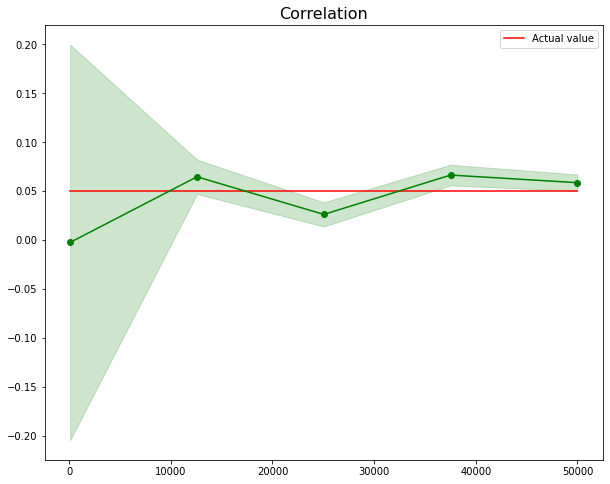

In [46]:
plot_correlation(distribution_matrix, np.linspace(100, 50000, 5).astype(int))